C:\w\1\s\tmp_conda_3.7_100118\conda\conda-bld\pytorch_1579082551706\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


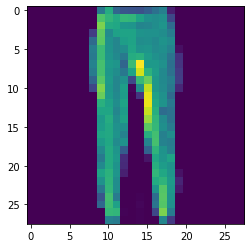

In [41]:
import torch
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torchvision
import torch.nn.functional as F
from tensorflow import keras
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torchvision import datasets
from sklearn.model_selection import train_test_split


# fashion_mnist = keras.datasets.fashion_mnist
# 
# # load dataset
# fashion_mnist = keras.datasets.fashion_mnist
# (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
# K = len(np.unique(train_labels))
# 
# X_train = np.reshape(train_images, (train_images.shape[0], train_images.shape[1]*train_images.shape[2]))
# X_test = np.reshape(test_images, (test_images.shape[0], test_images.shape[1]*test_images.shape[2]))
# 
# Y_train = np.zeros((train_labels.shape[0], K))
# Y_train[np.arange(Y_train.shape[0]), train_labels] = 1
# 
# Y_test = np.zeros((test_labels.shape[0], K))
# Y_test[np.arange(Y_test.shape[0]), test_labels] = 1
# 
# 
# X_test, X_validation, Y_test, Y_validation = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)
# 
# X_train = torch.tensor(X_train.T)
# X_validation = torch.tensor(X_validation.T)
# X_test = torch.tensor(X_test.T)
# 
# Y_train = torch.tensor(Y_train.T)
# Y_validation = torch.tensor(Y_validation.T)
# Y_test = torch.tensor(Y_test.T)

train_data = datasets.FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

valid_data = datasets.FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
                   
train_idx = np.random.choice(train_data.train_data.shape[0], 54000, replace=False)
train_data.data = train_data.data[train_idx, :]
train_data.targets = train_data.targets[torch.from_numpy(train_idx).type(torch.LongTensor)]
mask = np.ones(60000)
mask[train_idx] = 0
valid_data.data = valid_data.data[torch.from_numpy(np.argwhere(mask)), :].squeeze()
valid_data.targets = valid_data.targets[torch.from_numpy(mask).type(torch.ByteTensor)]
batch_size = 100
test_batch_size = 100

train_loader = torch.utils.data.DataLoader(train_data,
    batch_size=batch_size, shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_data,
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True)
plt.imshow(train_loader.dataset.train_data[1].numpy())

# 

In [42]:
class FcNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 300)
        self.fc2 = nn.Linear(300, 300)
        self.fc3 = nn.Linear(300, 10)

    def forward(self, image):
        batch_size = image.size()[0]
        x = image.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x
# 
# 

In [43]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # data, target = Variable(data, volatile=True).cuda(), Variable(target).cuda() # if you have access to a gpu
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)  # calls the forward function
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
    return model


def valid(model, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        # data, target = Variable(data, volatile=True).cuda(), Variable(target).cuda() # if you have access to a gpu
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        valid_loss += F.nll_loss(output, target, size_average=False).data # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    valid_loss /= len(valid_loader.dataset)
    print('\n' + "valid" + ' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        valid_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))
    return 1. * correct / len(valid_loader.dataset)


def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # data, target = Variable(data, volatile=True).cuda(), Variable(target).cuda() # if you have access to a gpu
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\n' + "test" + ' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def experiment(model, epochs=50, lr=0.001):
    best_model = model
    best_precision = 0
    optimizer = optim.SGD(model.parameters(), lr=lr)
    for epoch in range(1, epochs + 1):
        model = train(model, train_loader, optimizer)
        precision = valid(model, valid_loader)

        if precision > best_precision:
            best_precision = precision
            best_model = model
    return best_model, best_precision

In [44]:
best_model = None
best_precision = 0
for model in [FcNetwork()]:  # add your models in the list
    # model.cuda()  # if you have access to a gpu
    model, precision = experiment(model)
    if precision > best_precision:
        best_precision = precision
        best_model = model

test(best_model, test_loader)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



valid set: Average loss: 1.7622, Accuracy: 3700/6000 (62%)


valid set: Average loss: 1.2126, Accuracy: 3848/6000 (64%)


valid set: Average loss: 0.9705, Accuracy: 4049/6000 (67%)


valid set: Average loss: 0.8567, Accuracy: 4215/6000 (70%)


valid set: Average loss: 0.7886, Accuracy: 4319/6000 (72%)


valid set: Average loss: 0.7382, Accuracy: 4451/6000 (74%)


valid set: Average loss: 0.6996, Accuracy: 4561/6000 (76%)


valid set: Average loss: 0.6659, Accuracy: 4661/6000 (78%)


valid set: Average loss: 0.6380, Accuracy: 4702/6000 (78%)


valid set: Average loss: 0.6135, Accuracy: 4734/6000 (79%)


valid set: Average loss: 0.5951, Accuracy: 4764/6000 (79%)


valid set: Average loss: 0.5761, Accuracy: 4792/6000 (80%)


valid set: Average loss: 0.5613, Accuracy: 4836/6000 (81%)


valid set: Average loss: 0.5480, Accuracy: 4850/6000 (81%)


valid set: Average loss: 0.5365, Accuracy: 4870/6000 (81%)


valid set: Average loss: 0.5278, Accuracy: 4890/6000 (82%)


valid set: Average loss